# **Automated Model Tuning**

Notebook này trình bày về việc sử dụng điều chỉnh siêu tham số tự động để cải tiến mô hình máy học. Phương pháp ở đây là Bayesian Optimization và thư viện Hyperopt để điều chỉnh siêu tham số của GBM.

## Bayesian Optimization Primer



Vấn đề của grid và random search đó là chúng không phải phương pháp có sử dụng những kết quả cũ từ các giá trị khác nhau của những siêu tham số trong hàm mục tiêu. Tối ưu hóa Bayes là giới hạn các lệnh gọi đến hàm đánh giá bằng cách chọn các giá trị siêu tham số tiếp theo dựa trên các kết quả trước đó. Điều này cho phép thuật toán dành nhiều thời gian hơn để đánh giá các giá trị siêu tham số  và tốn ít thời gian hơn ở các vùng có điểm thấp của không gian siêu tham số. Ví dụ, hãy xem xét hình ảnh dưới đây:

![](https://raw.githubusercontent.com/WillKoehrsen/hyperparameter-optimization/master/images/random_forest_hypothetical.png)

Như hình trên thì ta nên tập trung vào khu vực có độ lỗi thấp. Tối ưu hóa Bayes hoạt động bằng cách xây dựng một hàm thay thế (dưới dạng mô hình xác suất) của hàm mục tiêu $P(\text{score} | \text{hyperparameters})$. Hàm thay thế tốn ít chi phí hơn nhiều để đánh giá so với hàm mục tiêu, vì vậy thuật toán chọn các giá trị tiếp theo để thử trong mục tiêu dựa trên việc tối đa hóa một tiêu chí trên hàm thay thế (thường là cải tiến được mong đợi).

Hàm thay thế dựa trên kết quả đánh giá trong quá khứ. Bayesian optimization dựa trên lý luận Bayes: hình thành một mô hình và sau đó cập nhật nó với nhiều thông tin hơn. Ý tưởng ở đây là khi dữ liệu đủ nhiều, hàm thay thế ngày càng gần hàm mục tiêu, và các siêu tham số tốt nhất cho hàm thay thế cũng sẽ tốt với hàm mục tiêu. Một số lựa chọn phổ biến là Gaussian Process, Random Forest Regression, và Tree Parzen Estimator.



### 4 Phần của Bayesian Optimization

Nó khá tương tự với 4 phần của grid và random search.

1. __Objective Function__: hàm mục tiêu, nhận về các siêu tham số và trả về điểm cần giảm thiểu hoặc tối ưu hoá
2. __Domain space__: khoảng các giá trị (siêu tham số) để tính toán
3. __Optimization Algorithm__: phương pháp sử dụng hàm thay thế và lựa chọn giá trị tiếp theo để tính toán
4. __Results__: điểm số và các cặp giá trị để thuật toán sử dụng cho việc xây dựng hàm thay thế

### Hyperopt

Hyperopt là một thư viện Python mã nguồn mở triển khai Bayesian Optimization bằng cách sử dụng thuật toán Tree Parzen Estimator để xây dựng hàm thay thế và chọn các giá trị siêu tham số tiếp theo để đánh giá trong hàm mục tiêu.

### Dataset and Approach

Tác giả sẽ thực hiện trước trên tập giới hạn với 10000 dữ liệu train, 6000 dữ liệu test. Sau khi áp dụng Bayesian hyperparameter optimization trên tập giới hạn này. Tác giả sẽ thực hiện tiếp trên toàn bộ đầy đủ tập dữ liệu.

## Thực hiện

### Import thư viện

In [ ]:
# Data manipulation
import pandas as pd
import numpy as np

# Modeling
import lightgbm as lgb

# Evaluation of the model
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import roc_auc_score

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['font.size'] = 18
%matplotlib inline

# Governing choices for search
N_FOLDS = 5
MAX_EVALS = 5

### Import Data

In [ ]:
features = pd.read_csv('../input/home-credit-default-risk/application_train.csv')

# Sample 16000 rows (10000 for training, 6000 for testing)
features = features.sample(n = 16000, random_state = 42)

# Only numeric features
features = features.select_dtypes('number')

# Extract the labels
labels = np.array(features['TARGET'].astype(np.int32)).reshape((-1, ))
features = features.drop(columns = ['TARGET', 'SK_ID_CURR'])

# Split into training and testing data
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 6000, random_state = 42)

print('Train shape: ', train_features.shape)
print('Test shape: ', test_features.shape)

train_features.head()

Train shape:  (10000, 104)
Test shape:  (6000, 104)


,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,...,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
99825,2,99000.0,562491.0,27189.0,454500.0,0.007330,-10901,-603,-574.0,-3572,22.0,1,1,0,1,0,0,4.0,2,2,11,0,0,0,0,1,1,NaN,0.364905,0.652897,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
208378,0,157500.0,677664.0,34731.0,585000.0,0.024610,-12091,-1358,-2918.0,-3715,NaN,1,1,1,1,1,0,1.0,2,2,15,1,1,0,1,1,0,0.298256,0.598669,0.661024,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0.0,2.0,0.0,-560.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,1.0,6.0
1309,2,112500.0,864000.0,25393.5,864000.0,0.028663,-11922,-1868,-1465.0,-4580,NaN,1,1,0,1,1,0,4.0,2,2,10,0,0,0,0,0,0,NaN,0.240739,0.577969,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,0.0,3.0,0.0,-1206.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
172223,1,63000.0,180000.0,9000.0,180000.0,0.020246,-14570,-7753,-5007.0,-4719,NaN,1,1,0,1,0,0,3.0,3,3,11,0,0,0,0,1,1,0.146889,0.428255,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-709.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
258157,0,202500.0,1193580.0,42417.0,855000.0,0.020713,-20925,-1049,-3149.0,-4437,64.0,1,1,0,1,0,0,2.0,3,2,12,0,0,0,0,0,0,NaN,0.053220,0.569149,0.1732,0.1072,0.9742,0.6464,0.0718,0.0,0.0345,0.1667,0.2083,0.0552,...,0.0345,0.1667,0.2083,0.0562,0.1437,0.0594,0.0,0.0,0.0851,4.0,0.0,4.0,0.0,-1184.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0


### Baseline Model 



Ta tạo một baseline model với các siêu tham số mặc định và tính độ đo của nó.

In [ ]:
model = lgb.LGBMClassifier(random_state=50)

# Training set
train_set = lgb.Dataset(train_features, label = train_labels)
test_set = lgb.Dataset(test_features, label = test_labels)

In [ ]:
# Default hyperparamters
hyperparameters = model.get_params()

# Using early stopping to determine number of estimators.
del hyperparameters['n_estimators']

# Perform cross validation with early stopping
cv_results = lgb.cv(hyperparameters, train_set, num_boost_round = 10000, nfold = N_FOLDS, metrics = 'auc', 
           early_stopping_rounds = 100, verbose_eval = False, seed = 42)

# Highest score
best = cv_results['auc-mean'][-1]

# Standard deviation of best score
best_std = cv_results['auc-stdv'][-1]

print('The maximium ROC AUC in cross validation was {:.5f} with std of {:.5f}.'.format(best, best_std))
print('The ideal number of iterations was {}.'.format(len(cv_results['auc-mean'])))

/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:661: UserWarning: silent keyword has been found in `params` and will be ignored. Please use silent argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))


The maximium ROC AUC in cross validation was 0.70867 with std of 0.02098.
The ideal number of iterations was 33.


Đánh giá trên tập "test".

In [ ]:
# Optimal number of esimators found in cv
model.n_estimators = len(cv_results['auc-mean'])

# Train and make predicions with model
model.fit(train_features, train_labels)
preds = model.predict_proba(test_features)[:, 1]
baseline_auc = roc_auc_score(test_labels, preds)

print('The baseline model scores {:.5f} ROC AUC on the test set.'.format(baseline_auc))

The baseline model scores 0.71466 ROC AUC on the test set.


## Objective Function



Hàm tối ưu hoá thường trả về việc giảm thiếu các giá trị, còn ROC AUC tốt khi đạt giá trị cao. Cho nên hàm mục tiêu sẽ trả về $1 - \text{ROC AUC Cross Validation}$. Kết quả trả về thấp, đồng nghĩa với ROC AUC cao.

Hàm này cũng sẽ lưu các giá trị vào file csv để theo dõi kết quả.

In [ ]:
import csv
from hyperopt import STATUS_OK
from timeit import default_timer as timer

def objective(hyperparameters):
    """Objective function for Gradient Boosting Machine Hyperparameter Optimization.
       Writes a new line to `outfile` on every iteration"""
    
    # Keep track of evals
    global ITERATION
    
    ITERATION += 1
    
    # Using early stopping to find number of trees trained
    if 'n_estimators' in hyperparameters:
        del hyperparameters['n_estimators']
    
    # Retrieve the subsample
    subsample = hyperparameters['boosting_type'].get('subsample', 1.0)
    
    # Extract the boosting type and subsample to top level keys
    hyperparameters['boosting_type'] = hyperparameters['boosting_type']['boosting_type']
    hyperparameters['subsample'] = subsample
    
    # Make sure parameters that need to be integers are integers
    for parameter_name in ['num_leaves', 'subsample_for_bin', 'min_child_samples']:
        hyperparameters[parameter_name] = int(hyperparameters[parameter_name])

    start = timer()
    
    # Perform n_folds cross validation
    cv_results = lgb.cv(hyperparameters, train_set, num_boost_round = 10000, nfold = N_FOLDS, 
                        early_stopping_rounds = 100, metrics = 'auc', seed = 50)

    run_time = timer() - start
    
    # Extract the best score
    best_score = cv_results['auc-mean'][-1]
    
    # Loss must be minimized
    loss = 1 - best_score
    
    # Boosting rounds that returned the highest cv score
    n_estimators = len(cv_results['auc-mean'])
    
    # Add the number of estimators to the hyperparameters
    hyperparameters['n_estimators'] = n_estimators

    # Write to the csv file ('a' means append)
    of_connection = open(OUT_FILE, 'a')
    writer = csv.writer(of_connection)
    writer.writerow([loss, hyperparameters, ITERATION, run_time, best_score])
    of_connection.close()

    # Dictionary with information for evaluation
    return {'loss': loss, 'hyperparameters': hyperparameters, 'iteration': ITERATION,
            'train_time': run_time, 'status': STATUS_OK}

## Miền giá trị (Domain)



Đối với mỗi siêu tham số, miền biểu thị xác suất cho mỗi siêu tham số. Sử dụng thư viện hyperopt để xác định miền cho các siêu tham số.

In [ ]:
from hyperopt import hp
from hyperopt.pyll.stochastic import sample

### Miền của Learning rate

Tác giả sử dụng không gian logarit cho learning rate từ 0.005 đến 0.5.

In [ ]:
# Create the learning rate
learning_rate = {'learning_rate': hp.loguniform('learning_rate', np.log(0.005), np.log(0.2))}

Tác giả tiến hành trực quan hoá phân phối learning rate của 10000 mẫu.

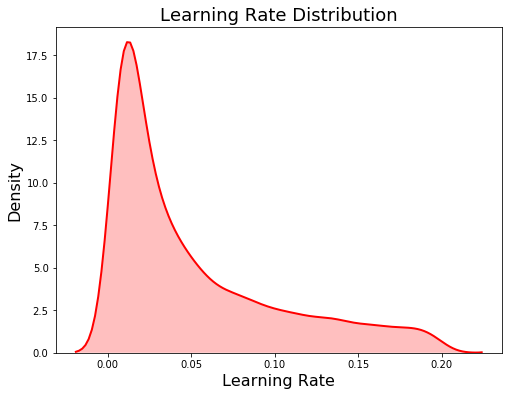

In [ ]:
learning_rate_dist = []

# Draw 10000 samples from the learning rate domain
for _ in range(10000):
    learning_rate_dist.append(sample(learning_rate)['learning_rate'])
    
plt.figure(figsize = (8, 6))
sns.kdeplot(learning_rate_dist, color = 'red', linewidth = 2, shade = True);
plt.title('Learning Rate Distribution', size = 18); plt.xlabel('Learning Rate', size = 16); plt.ylabel('Density', size = 16);

Phân phối của số lượng lá là phân phối đều rời rạc.

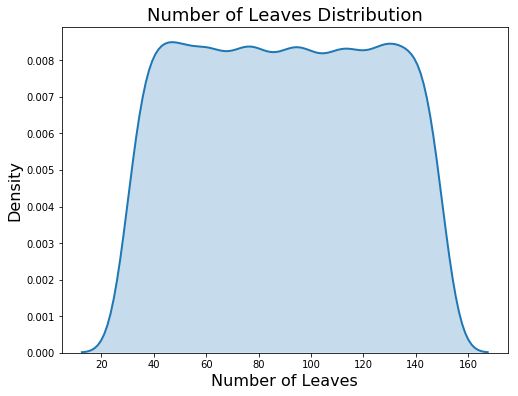

In [ ]:
# Discrete uniform distribution
num_leaves = {'num_leaves': hp.quniform('num_leaves', 30, 150, 1)}
num_leaves_dist = []

# Sample 10000 times from the number of leaves distribution
for _ in range(10000):
    num_leaves_dist.append(sample(num_leaves)['num_leaves'])
    
# kdeplot
plt.figure(figsize = (8, 6))
sns.kdeplot(num_leaves_dist, linewidth = 2, shade = True);
plt.title('Number of Leaves Distribution', size = 18); plt.xlabel('Number of Leaves', size = 16); plt.ylabel('Density', size = 16);

### Miền có điều kiện



Trong Hyperopt, ta có thể sử dụng câu lệnh điều kiện để thể hiện việc các siêu  tham số phụ thuộc vào siêu tham số khác, ví dụ giữa boosting_type và subsample.Khi boosting_type = goss, thì ta không thể lấy subsample, do đó phải gán nó bằng 1.0. Còn với các type khác thì có giá trị từ 0.5 -> 1.0.

In [ ]:
# boosting type domain 
boosting_type = {'boosting_type': hp.choice('boosting_type', 
                                            [{'boosting_type': 'gbdt', 'subsample': hp.uniform('subsample', 0.5, 1)}, 
                                             {'boosting_type': 'dart', 'subsample': hp.uniform('subsample', 0.5, 1)},
                                             {'boosting_type': 'goss', 'subsample': 1.0}])}

# Draw a sample
hyperparams = sample(boosting_type)
hyperparams

{'boosting_type': {'boosting_type': 'goss', 'subsample': 1.0}}

Đặt boosting_type và subsamples là những khoá cấp cao của từ điển tham số, bởi vì gbm không thể sử dụng từ điển lồng nhau. Khi không có giá trị thì mặc định sẽ được trả về (1.0).

In [ ]:
# Retrieve the subsample if present otherwise set to 1.0
subsample = hyperparams['boosting_type'].get('subsample', 1.0)

# Extract the boosting type
hyperparams['boosting_type'] = hyperparams['boosting_type']['boosting_type']
hyperparams['subsample'] = subsample

hyperparams

{'boosting_type': 'goss', 'subsample': 1.0}

### Miền hoàn chỉnh của Bayesian


Tổng hợp lại, tương tự với grid và random search, sẽ có 10 siêu tham số được lựa chọn.

In [ ]:
# Define the search space
space = {
    'boosting_type': hp.choice('boosting_type', 
                                            [{'boosting_type': 'gbdt', 'subsample': hp.uniform('gdbt_subsample', 0.5, 1)}, 
                                             {'boosting_type': 'dart', 'subsample': hp.uniform('dart_subsample', 0.5, 1)},
                                             {'boosting_type': 'goss', 'subsample': 1.0}]),
    'num_leaves': hp.quniform('num_leaves', 20, 150, 1),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.5)),
    'subsample_for_bin': hp.quniform('subsample_for_bin', 20000, 300000, 20000),
    'min_child_samples': hp.quniform('min_child_samples', 20, 500, 5),
    'reg_alpha': hp.uniform('reg_alpha', 0.0, 1.0),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 1.0),
    'colsample_bytree': hp.uniform('colsample_by_tree', 0.6, 1.0),
    'is_unbalance': hp.choice('is_unbalance', [True, False]),
}

### Ví dụ cách lấy mẫu từ miền


In [ ]:
# Sample from the full space
x = sample(space)

# Conditional logic to assign top-level keys
subsample = x['boosting_type'].get('subsample', 1.0)
x['boosting_type'] = x['boosting_type']['boosting_type']
x['subsample'] = subsample

x

{'boosting_type': 'dart',
 'colsample_bytree': 0.9004226910395037,
 'is_unbalance': False,
 'learning_rate': 0.035637182513880525,
 'min_child_samples': 155.0,
 'num_leaves': 49.0,
 'reg_alpha': 0.7756726426783026,
 'reg_lambda': 0.5941386345311841,
 'subsample': 0.9992612301921683,
 'subsample_for_bin': 240000.0}

In [ ]:
x = sample(space)
subsample = x['boosting_type'].get('subsample', 1.0)
x['boosting_type'] = x['boosting_type']['boosting_type']
x['subsample'] = subsample
x

{'boosting_type': 'goss',
 'colsample_bytree': 0.887514076717528,
 'is_unbalance': False,
 'learning_rate': 0.1273754097313474,
 'min_child_samples': 130.0,
 'num_leaves': 29.0,
 'reg_alpha': 0.6343036862105076,
 'reg_lambda': 0.3033330570902607,
 'subsample': 1.0,
 'subsample_for_bin': 220000.0}

Kiểm tra tính đúng của hàm mục tiêu với các miền.

In [ ]:
# Create a new file and open a connection
OUT_FILE = 'bayes_test.csv'
of_connection = open(OUT_FILE, 'w')
writer = csv.writer(of_connection)

ITERATION = 0

# Write column names
headers = ['loss', 'hyperparameters', 'iteration', 'runtime', 'score']
writer.writerow(headers)
of_connection.close()

# Test the objective function
results = objective(sample(space))
print('The cross validation loss = {:.5f}.'.format(results['loss']))
print('The optimal number of estimators was {}.'.format(results['hyperparameters']['n_estimators']))

The cross validation loss = 0.30562.
The optimal number of estimators was 9.


## Thuật toán tối ưu hoá



Thuật toán tối ưu hóa là phương pháp xây dựng hàm thay thế (mô hình xác suất) và chọn tập siêu tham số tiếp theo để đánh giá trong hàm mục tiêu. Hyperopt có hai lựa chọn: tìm kiếm ngẫu nhiên và Tree Parzen Estimator.

Chi tiết về TPE có thể xem [tại đây](https://papers.nips.cc/paper/4443-algorithms-for-hyper-parameter-optimization.pdf) và [đây](https://towardsdatascience.com/a-conceptual-explanation-of-bayesian-model-based-hyperparameter-optimization-for-machine-learning-b8172278050f).

In [ ]:
from hyperopt import tpe

# Create the algorithm
tpe_algorithm = tpe.suggest

## Lịch sử các kết quả thực hiện


Hyperopt có cơ chế lưu giữ lại kết quả của thuật toán, nếu ta muốn tự theo dõi thì tác giả có 2 phương pháp:

1. Một đối tượng `Trials` lưu trữ từ điển được hàm mục tiêu trả về.
2. Thêm một dòng vào file csv ở mỗi lần lặp

In [ ]:
from hyperopt import Trials

# Record results
trials = Trials()

In [ ]:
# Create a file and open a connection
OUT_FILE = 'bayes_test.csv'
of_connection = open(OUT_FILE, 'w')
writer = csv.writer(of_connection)

ITERATION = 0

# Write column names
headers = ['loss', 'hyperparameters', 'iteration', 'runtime', 'score']
writer.writerow(headers)
of_connection.close()

## Automated Hyperparameter Optimization trong thực tế

Ta sử dụng `fmin` để chạy Bayesian optimization.

In [ ]:
from hyperopt import fmin

`fmin` thực hiện toàn bộ 4 phần ở trên và với số lần lặp lại là `max_evals`. 

In [ ]:
# MAX_EVALS = 5
# Global variable
global  ITERATION

ITERATION = 0

# Run optimization
best = fmin(fn = objective, space = space, algo = tpe.suggest, trials = trials,
            max_evals = MAX_EVALS)

best

{'boosting_type': 0,
 'colsample_by_tree': 0.6345878959069463,
 'gdbt_subsample': 0.5067080370291421,
 'is_unbalance': 0,
 'learning_rate': 0.05151635822694547,
 'min_child_samples': 435.0,
 'num_leaves': 55.0,
 'reg_alpha': 0.8212755266681537,
 'reg_lambda': 0.6241781147045755,
 'subsample_for_bin': 260000.0}

`best` sẽ giữ các siêu tham số cho ra giá trị thấp nhất ở hàm mục tiêu. Nếu ta muốn theo dõi các bước thì thông qua `Trials` hoặc file `csv`.

In [ ]:
# Sort the trials with lowest loss (highest AUC) first
trials_dict = sorted(trials.results, key = lambda x: x['loss'])
trials_dict[:1]

[{'hyperparameters': {'boosting_type': 'gbdt',
   'colsample_bytree': 0.6345878959069463,
   'is_unbalance': True,
   'learning_rate': 0.05151635822694547,
   'metric': 'auc',
   'min_child_samples': 435,
   'n_estimators': 62,
   'num_leaves': 55,
   'reg_alpha': 0.8212755266681537,
   'reg_lambda': 0.6241781147045755,
   'subsample': 0.5067080370291421,
   'subsample_for_bin': 260000,
   'verbose': 1},
  'iteration': 4,
  'loss': 0.2763582856744454,
  'status': 'ok',
  'train_time': 2.5303897860000006}]

In [ ]:
results = pd.read_csv(OUT_FILE)

Hàm bên dưới nhận kết quả, đào tạo một mô hình trên dữ liệu đào tạo và đánh giá trên dữ liệu tập test. Nó trả về một dataframes các siêu tham số.

Ta lưu kết quả vào file csv, ở file csv kết quả sẽ được lưu thành string. Ta dùng `ast.literal_eval` để chuyển lại thành từ điển.

In [ ]:
import ast

def evaluate(results, name):
    """Evaluate model on test data using hyperparameters in results
       Return dataframe of hyperparameters"""
    
    new_results = results.copy()
    # String to dictionary
    new_results['hyperparameters'] = new_results['hyperparameters'].map(ast.literal_eval)
    
    # Sort with best values on top
    new_results = new_results.sort_values('score', ascending = False).reset_index(drop = True)
    
    # Print out cross validation high score
    print('The highest cross validation score from {} was {:.5f} found on iteration {}.'.format(name, new_results.loc[0, 'score'], new_results.loc[0, 'iteration']))
    
    # Use best hyperparameters to create a model
    hyperparameters = new_results.loc[0, 'hyperparameters']
    model = lgb.LGBMClassifier(**hyperparameters)
    
    # Train and make predictions
    model.fit(train_features, train_labels)
    preds = model.predict_proba(test_features)[:, 1]
    
    print('ROC AUC from {} on test data = {:.5f}.'.format(name, roc_auc_score(test_labels, preds)))
    
    # Create dataframe of hyperparameters
    hyp_df = pd.DataFrame(columns = list(new_results.loc[0, 'hyperparameters'].keys()))

    # Iterate through each set of hyperparameters that were evaluated
    for i, hyp in enumerate(new_results['hyperparameters']):
        hyp_df = hyp_df.append(pd.DataFrame(hyp, index = [0]), 
                               ignore_index = True)
        
    # Put the iteration and score in the hyperparameter dataframe
    hyp_df['iteration'] = new_results['iteration']
    hyp_df['score'] = new_results['score']
    
    return hyp_df

In [ ]:
bayes_results = evaluate(results, name = 'Bayesian')
bayes_results

The highest cross validation score from Bayesian was 0.72364 found on iteration 4.
ROC AUC from Bayesian on test data = 0.73203.


,boosting_type,colsample_bytree,is_unbalance,learning_rate,min_child_samples,num_leaves,reg_alpha,reg_lambda,subsample_for_bin,subsample,metric,verbose,n_estimators,iteration,score
0,gbdt,0.634588,True,0.051516,435,55,0.821276,0.624178,260000,0.506708,auc,1,62,4,0.723642
1,gbdt,0.942109,True,0.062881,285,89,0.354825,0.415758,300000,0.931245,auc,1,59,3,0.719821
2,goss,0.887178,False,0.020036,345,52,0.575276,0.956006,60000,1.000000,auc,1,44,2,0.713146
3,dart,0.810545,True,0.014059,55,141,0.221686,0.234394,60000,0.551837,auc,1,165,1,0.707571
4,goss,0.667251,True,0.230532,435,95,0.778742,0.616788,100000,1.000000,auc,1,4,5,0.701750


## Tiếp tục tối ưu hoá (nếu cần)

Nhờ vào đối tượng `Trials` ta có thể thực hiện tiếp quá trình tìm kiếm bất cứ lúc nào. Chỉ cần truyền `Trials` vào `fmin`.

In [ ]:
MAX_EVALS = 10

# Continue training
best = fmin(fn = objective, space = space, algo = tpe.suggest, trials = trials,
            max_evals = MAX_EVALS)

Lưu  `Trials` vào file `json` để có thể huấn luyện sau này.

In [ ]:
import json

# Save the trial results
with open('trials.json', 'w') as f:
    f.write(json.dumps(trials_dict))

## Thực hiện trên tập Limited Data


Tác giả chạy 1000 lần tính toán trên tập dữ liệu giới hạn để so sánh. Nhóm đã thực hiện trước và lưu lại file các file csv vào dataset "Home Credit Team8 Model Tuning" nên đoạn code dưới này được comment lại.

In [ ]:
# MAX_EVALS = 1000

# # Create a new file and open a connection
# OUT_FILE = 'bayesian_trials_1000.csv'
# of_connection = open(OUT_FILE, 'w')
# writer = csv.writer(of_connection)

# # Write column names
# headers = ['loss', 'hyperparameters', 'iteration', 'runtime', 'score']
# writer.writerow(headers)
# of_connection.close()

# # Record results
# trials = Trials()

# global ITERATION

# ITERATION = 0 

# best = fmin(fn = objective, space = space, algo = tpe.suggest,
#             trials = trials, max_evals = MAX_EVALS)

# # Sort the trials with lowest loss (highest AUC) first
# trials_dict = sorted(trials.results, key = lambda x: x['loss'])

# print('Finished, best results')
# print(trials_dict[:1])

# # Save the trial results
# with open('trials.json', 'w') as f:
#     f.write(json.dumps(trials_dict))

## Kết quả thực hiện

Kết quả thực hiện trên tập Limited Data với 1000 lần lặp. Sau bước này ta sẽ sử dụng giá trị của các siêu tham số tìm được để áp dụng cho toàn bộ dữ liệu của cuộc thi. Ở đa ta sẽ lấy dữ liệu của cả Random Search để so sánh.

In [ ]:
bayes_results = pd.read_csv('../input/home-credit-team8-model-tuning/bayesian_trials_1000.csv').sort_values('score', ascending = False).reset_index()
random_results = pd.read_csv('../input/home-credit-team8-model-tuning/random_search_trials_1000.csv').sort_values('score', ascending = False).reset_index()
random_results['loss'] = 1 - random_results['score']

bayes_params = evaluate(bayes_results, name = 'Bayesian')
random_params = evaluate(random_results, name = 'random')

The highest cross validation score from Bayesian was 0.72876 found on iteration 769.
ROC AUC from Bayesian on test data = 0.73010.
The highest cross validation score from random was 0.72986 found on iteration 474.
ROC AUC from random on test data = 0.73590.


So với Random Search: Bayesian có điểm thấp hơn khi xác thực chéo tuy nhiên đạt điểm cao hơn trên tập test.

## Visualizations

### Độ đo ROC AUC qua mỗi lần lặp

In [ ]:
# Dataframe of just scores
scores = pd.DataFrame({'ROC AUC': random_params['score'], 'iteration': random_params['iteration'], 'search': 'Random'})
scores = scores.append(pd.DataFrame({'ROC AUC': bayes_params['score'], 'iteration': bayes_params['iteration'], 'search': 'Bayesian'}))

scores['ROC AUC'] = scores['ROC AUC'].astype(np.float32)
scores['iteration'] = scores['iteration'].astype(np.int32)

scores.head()

,ROC AUC,iteration,search
0,0.729855,474,Random
1,0.729518,381,Random
2,0.729383,453,Random
3,0.729338,164,Random
4,0.729225,704,Random


In [ ]:
best_random_params = random_params.iloc[random_params['score'].idxmax(), :].copy()
best_bayes_params = bayes_params.iloc[bayes_params['score'].idxmax(), :].copy()

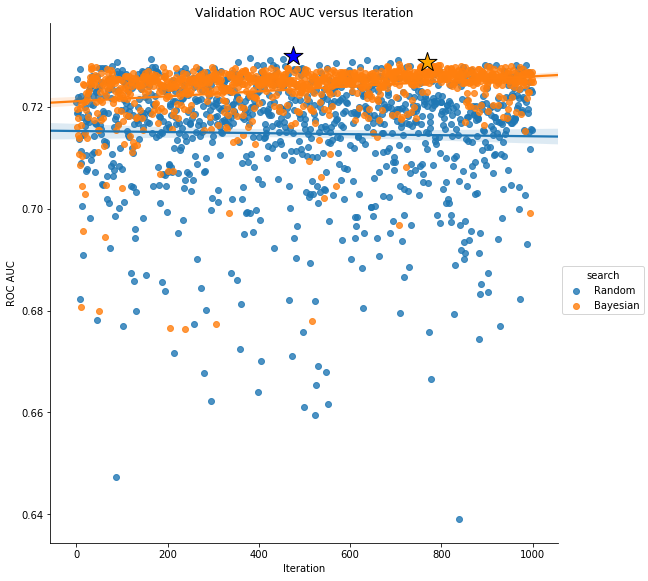

In [ ]:
# Plot of scores over the course of searching
sns.lmplot('iteration', 'ROC AUC', hue = 'search', data = scores, size = 8);
plt.scatter(best_bayes_params['iteration'], best_bayes_params['score'], marker = '*', s = 400, c = 'orange', edgecolor = 'k')
plt.scatter(best_random_params['iteration'], best_random_params['score'], marker = '*', s = 400, c = 'blue', edgecolor = 'k')
plt.xlabel('Iteration'); plt.ylabel('ROC AUC'); plt.title("Validation ROC AUC versus Iteration");

Nhận xét: Random Search cho kết quả tốt hơn tuy nhiên điểm số không được cải thiện qua các lần lặp. Còn Bayesian cho thấy điểm số tăng dần và hứa hẹn sẽ cho kết quả cao hơn.

### Biểu đồ phân phối của Learning Rate

Phân phối của Random Search phù hợp với miền tìm kiếm, còn Bayesian có xu hướng tập trung vào các giá trị hứa hẹn.

Các đường thẳng đứng đứt nét biểu thị giá trị "tối ưu" của siêu tham số.

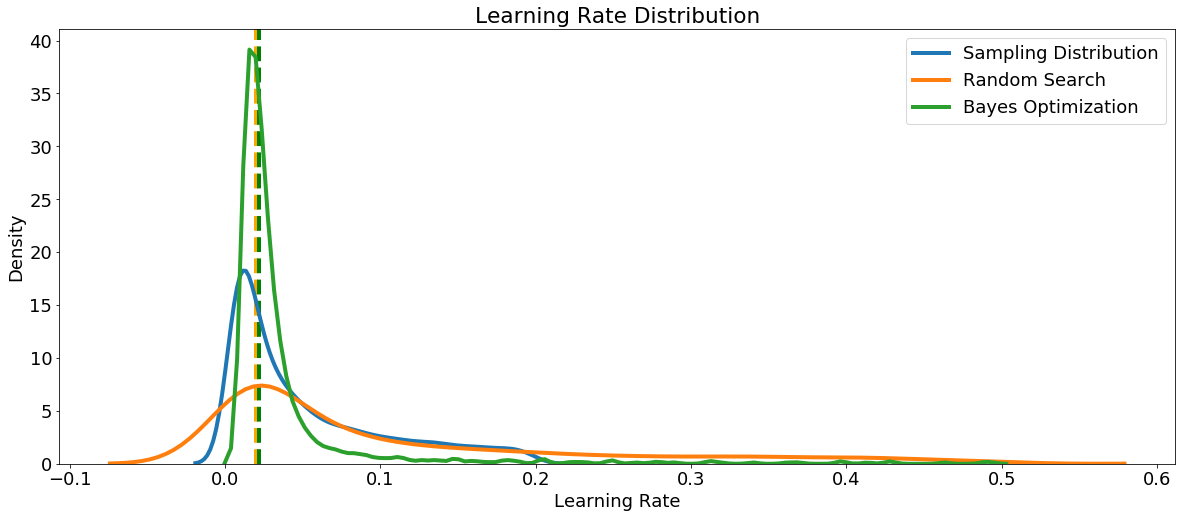

In [ ]:
plt.figure(figsize = (20, 8))
plt.rcParams['font.size'] = 18

# Density plots of the learning rate distributions 
sns.kdeplot(learning_rate_dist, label = 'Sampling Distribution', linewidth = 4)
sns.kdeplot(random_params['learning_rate'], label = 'Random Search', linewidth = 4)
sns.kdeplot(bayes_params['learning_rate'], label = 'Bayes Optimization', linewidth = 4)
plt.vlines([best_random_params['learning_rate'], best_bayes_params['learning_rate']],
           ymin = 0.0, ymax = 50.0, linestyles = '--', linewidth = 4, colors = ['orange', 'green'])
plt.legend()
plt.xlabel('Learning Rate'); plt.ylabel('Density'); plt.title('Learning Rate Distribution');

### Một số biểu đồ phân phối của các siêu tham số khác

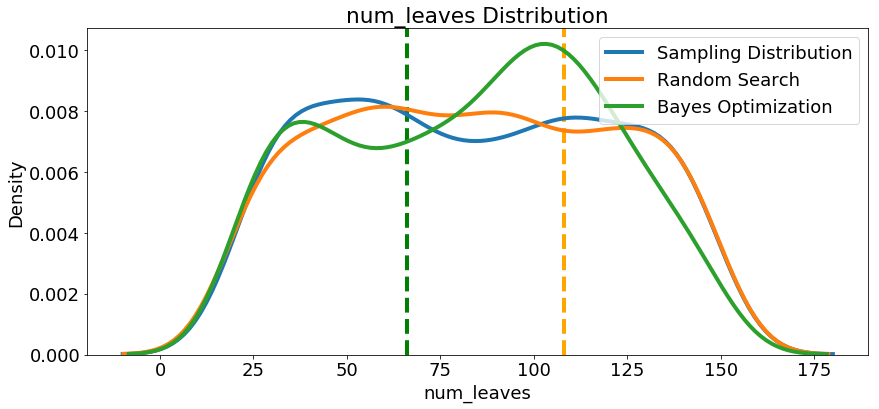

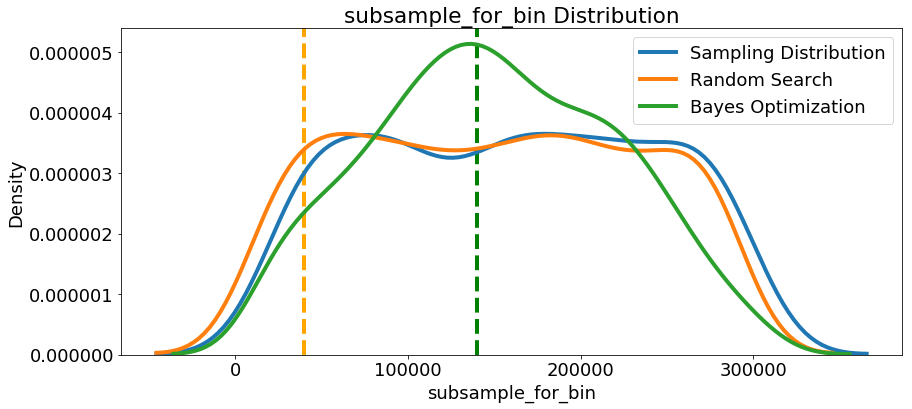

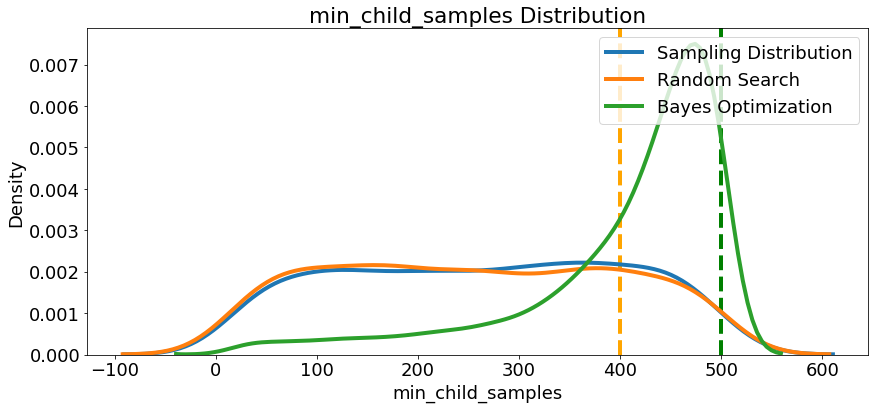

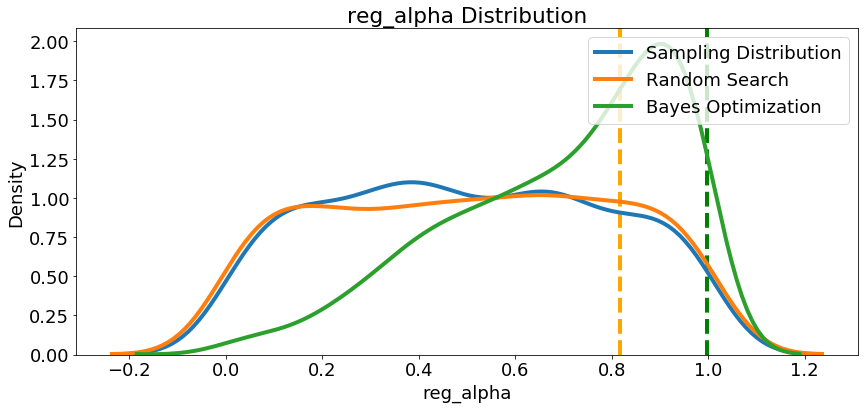

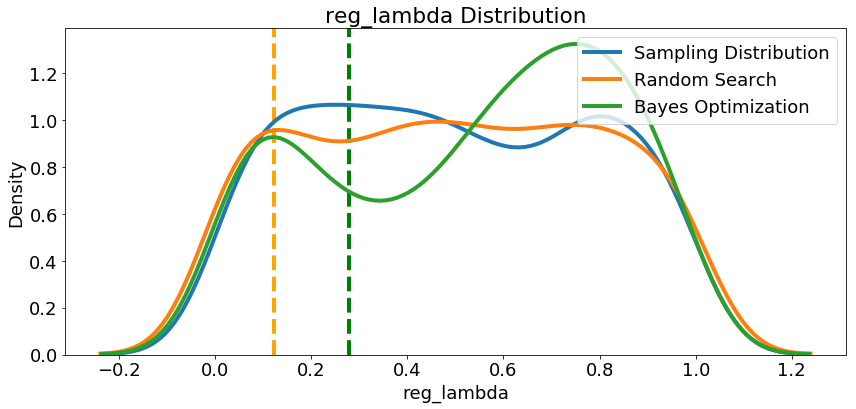

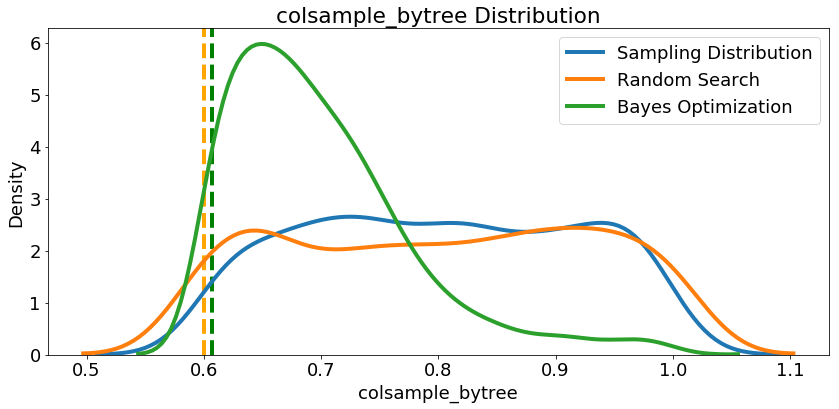

In [ ]:
# Iterate through each hyperparameter
for i, hyper in enumerate(random_params.columns):
    if hyper not in ['class_weight', 'n_estimators', 'score', 'is_unbalance',
                    'boosting_type', 'iteration', 'subsample', 'metric', 'verbose', 'loss', 'learning_rate']:
        plt.figure(figsize = (14, 6))
        # Plot the random search distribution and the bayes search distribution
        if hyper != 'loss':
            sns.kdeplot([sample(space[hyper]) for _ in range(1000)], label = 'Sampling Distribution', linewidth = 4)
        sns.kdeplot(random_params[hyper], label = 'Random Search', linewidth = 4)
        sns.kdeplot(bayes_params[hyper], label = 'Bayes Optimization', linewidth = 4)
        plt.vlines([best_random_params[hyper], best_bayes_params[hyper]],
                     ymin = 0.0, ymax = 10.0, linestyles = '--', linewidth = 4, colors = ['orange', 'green'])
        plt.legend(loc = 1)
        plt.title('{} Distribution'.format(hyper))
        plt.xlabel('{}'.format(hyper)); plt.ylabel('Density');
        plt.show();

## Áp dụng trên toàn bộ tập dữ liệu

Sử dụng các siêu tham số tốt nhất được tìm ra từ random search để áp dụng cho toàn bộ tập dữ liệu sau khi đã tiền xử lý của nhóm.

In [ ]:
# Read in full dataset
train = pd.read_csv('../input/home-credit-team8-dataset3/final_train_3.csv')
test = pd.read_csv('../input/home-credit-team8-dataset3/final_test_3.csv')

# Extract the test ids and train labels
test_ids = test['SK_ID_CURR']
train_labels = np.array(train['TARGET'].astype(np.int32)).reshape((-1, ))

train = train.drop(columns = ['SK_ID_CURR', 'TARGET'])
test = test.drop(columns = ['SK_ID_CURR'])

print('Training shape: ', train.shape)
print('Testing shape: ', test.shape)

Training shape:  (307511, 416)
Testing shape:  (48744, 416)


In [ ]:
random_results['hyperparameters'] = random_results['hyperparameters'].map(ast.literal_eval)
bayes_results['hyperparameters'] = bayes_results['hyperparameters'].map(ast.literal_eval)

### Random Search

In [ ]:
train_set = lgb.Dataset(train, label = train_labels)

hyperparameters = dict(**random_results.loc[0, 'hyperparameters'])
del hyperparameters['n_estimators']

# Cross validation with n_folds and early stopping
cv_results = lgb.cv(hyperparameters, train_set,
                    num_boost_round = 10000, early_stopping_rounds = 100, 
                    metrics = 'auc', nfold = N_FOLDS)

print('The cross validation score on the full dataset  for Random Search= {:.5f} with std: {:.5f}.'.format(
    cv_results['auc-mean'][-1], cv_results['auc-stdv'][-1]))
print('Number of estimators = {}.'.format(len(cv_results['auc-mean'])))

The cross validation score on the full dataset  for Random Search= 0.78518 with std: 0.00270.
Number of estimators = 774.


In [ ]:
model = lgb.LGBMClassifier(n_estimators = len(cv_results['auc-mean']), **hyperparameters)
model.fit(train, train_labels)

preds = model.predict_proba(test)[:, 1]

submission = pd.DataFrame({'SK_ID_CURR': test_ids, 'TARGET': preds})
submission.to_csv('submission_random_search.csv', index = False)

Điểm số khi submit là:
- Public Leaderboard: __0.79168__.
- Private Leaderboard: __0.78756__.

### Bayesian Optimization

In [ ]:
hyperparameters = dict(**bayes_results.loc[0, 'hyperparameters'])
del hyperparameters['n_estimators']

# Cross validation with n_folds and early stopping
cv_results = lgb.cv(hyperparameters, train_set,
                    num_boost_round = 10000, early_stopping_rounds = 100, 
                    metrics = 'auc', nfold = N_FOLDS)

print('The cross validation score on the full dataset for Bayesian optimization = {:.5f} with std: {:.5f}.'.format(
    cv_results['auc-mean'][-1], cv_results['auc-stdv'][-1]))
print('Number of estimators = {}.'.format(len(cv_results['auc-mean'])))

The cross validation score on the full dataset for Bayesian optimization = 0.78529 with std: 0.00295.
Number of estimators = 772.


In [ ]:
model = lgb.LGBMClassifier(n_estimators = len(cv_results['auc-mean']), **hyperparameters)
model.fit(train, train_labels)

preds = model.predict_proba(test)[:, 1]

submission = pd.DataFrame({'SK_ID_CURR': test_ids, 'TARGET': preds})
submission.to_csv('submission_bayesian_optimization.csv', index = False)

Điểm số khi submit là:
- Public Leaderboard: __0.79124__.
- Private Leaderboard: __0.78834__.

# Kết luận

- Không có quá nhiều chênh lệch ở kết quả giữa Random Search và Automated bằng Bayesian Optimization.
- Tuy nhiên Bayesian mang đến nhiều hứa hẹn sẽ đưa ra được một kết quả tốt hơn vì nó có thời gian nhanh hơn và tập trung vào những điểm có triển vọng hơn so với Random Search.